### dev notebook

In [1]:
import os
import numpy as np
import pandas as pd

#### functions

In [2]:
def full_labels(csv_name, save=True):
    """getting full set of labels for features"""
    # load data
    print(f'./labels/label_{csv_name}.csv')
    labels = pd.read_csv(f'./labels/label_{csv_name}.csv')
    sj_bmrc = pd.read_csv(f'./bmrc_subjs/subjs_{csv_name}.csv', header=None)
    sj_full = pd.read_csv(f'./bmrc_full/subjs_{csv_name}.csv')
    # rename columns
    sj_bmrc.rename(columns={0:'bmrc'}, inplace=True)
    sj_full.rename(columns={'eid':'bmrc_eid'}, inplace=True)
    print(sj_full.shape)
    # merge
    bmrc_full = sj_bmrc.merge(sj_full, left_on='bmrc', right_on='bmrc_eid', how='left',indicator=True)
    # concat with labels
    full_df = pd.concat([labels, bmrc_full], axis=1)
    df_out = full_df[full_df['_merge']=='both']
    df_out_clean = df_out.drop(columns=['bmrc_eid', '_merge']).reset_index(drop=True)
    print(df_out_clean.shape)
    # save
    if save:
        save_path = f'./labels_full/label_{csv_name}.csv'
        df_out_clean.to_csv(save_path, index=None)
    return df_out_clean

In [3]:
def remove_subjs(feat_path, df_label):
    """remove participants with multiple conditions"""
    feats = np.load(os.path.join(feat_path, 'subj_course.npy'))
    exclude = df_label[df_label[['irritable bowel syndrome', 'back pain', 'migraine','osteoarthritis']].sum(axis=1)>1]['eid']
    df_featout = pd.concat([df_label, pd.DataFrame(feats)], axis=1)
    df_featout_ex = df_featout[~df_featout['eid'].isin(exclude.values)]
    return df_featout_ex

In [4]:
def data_prep(df):
    """prepare df to x and y for clf"""
    # dummify labels
    X = df[(n for n in range(0,30))].to_numpy()
    if df.shape[1]>33:
        y_original = df[['irritable bowel syndrome', 'migraine', 'back pain',
       'osteoarthritis']]
        y = y_original.idxmax(axis=1)
    else:
        y = df['label']
    return X, y

In [5]:
def cv_classify(df, classifier='dtree', cv_fold=10, scaler=True, balance=True):
    """n-fold cross validation classification"""
    from sklearn.model_selection import cross_validate

    X, y = data_prep(df)
    # balance dataset
    if balance:
        from imblearn.under_sampling import RandomUnderSampler
        # define undersampling strategy
        under = RandomUnderSampler(random_state=0)
        # fit and apply the transform
        X, y = under.fit_resample(X, y)
    # apply scaler
    if scaler:
        from sklearn.preprocessing import StandardScaler
        X = StandardScaler().fit_transform(X)

    # define classifier
    if classifier == 'dtree':
        from sklearn.tree import DecisionTreeClassifier
        clf = DecisionTreeClassifier(max_depth=5)
    elif classifier == 'rforest':
        from sklearn.ensemble import RandomForestClassifier
        clf = RandomForestClassifier(max_depth=5)
    elif classifier == 'lgb':
        import lightgbm as lgb
        clf = lgb.LGBMClassifier(n_jobs=-1)
    # cv result
    print(len(np.unique(y)))
    if len(np.unique(y)) <= 2: # binary
        cv_results = cross_validate(clf, X, y, cv=cv_fold, return_train_score=False, scoring=('accuracy', 'f1', 'roc_auc'))
        df_res = pd.DataFrame(cv_results)
        # print res
        print(f"{cv_fold}-fold CV classification with classifier {clf}:\n"
            f"test ROC AUC={df_res['test_roc_auc'].mean():.4f}, test accuracy={df_res['test_accuracy'].mean():.4f}, test f1={df_res['test_f1'].mean():.4f}")
    else:
        cv_results = cross_validate(clf, X, y, cv=cv_fold, return_train_score=False, scoring=('accuracy', 'f1_micro', 'roc_auc_ovo'))
        df_res = pd.DataFrame(cv_results)
        # print res
        print(f"{cv_fold}-fold CV classification with classifier {clf}:\n"
            f"test ROC AUC={df_res['test_roc_auc_ovo'].mean():.4f}, test accuracy={df_res['test_accuracy'].mean():.4f}, test f1={df_res['test_f1_micro'].mean():.4f}")

    return df_res


In [28]:
def load_mask(img_data):
    """load mask and return mask"""
    import nibabel as nib
    curr_dir = '/well/seymour/users/uhu195/python/extract_npy'
    
    # check image shape
    img_len = img_data.shape[0]
    
    if img_len < 100: 
        mask_path = os.path.join(curr_dir, 'MNI152_T1_2mm_brain.nii.gz')
    else:
        mask_path = os.path.join(curr_dir, 'MNI152_T1_1mm_brain.nii.gz')
    mask_dat = nib.load(mask_path).get_fdata()>0
    return mask_dat

### digestive data classification and reconstruction

In [6]:
df_label = full_labels('digestive')

./labels/label_digestive.csv
(3817, 1)
(3817, 3)


In [7]:
data_dir = '../pain/output_digestive/Result_IC30'
feats = np.load(os.path.join(data_dir, 'subj_course.npy'))

In [8]:
feats.shape

(3817, 30)

In [9]:
df_featout = pd.concat([df_label, pd.DataFrame(feats)], axis=1)

In [10]:
df_featout.shape

(3817, 33)

In [12]:
cv_classify(df_featout, classifier='rforest', cv_fold=10, 
            scaler=True, balance=True)

2
10-fold CV classification with classifier RandomForestClassifier(max_depth=5):
test ROC AUC=0.5863, test accuracy=0.5594, test f1=0.5457


,fit_time,score_time,test_accuracy,test_f1,test_roc_auc
0,0.496667,0.024603,0.556391,0.549618,0.595737
1,0.497848,0.024658,0.560150,0.551724,0.566906
2,0.498088,0.024582,0.620301,0.643110,0.624965
3,0.496066,0.025053,0.507519,0.490272,0.542201
4,0.500766,0.025947,0.537594,0.532319,0.583074
5,0.496240,0.025080,0.560150,0.526316,0.600317
6,0.496113,0.024957,0.590226,0.572549,0.612245
7,0.496992,0.024816,0.578947,0.585185,0.598168
8,0.496095,0.024827,0.528302,0.485597,0.530189
9,0.498350,0.024914,0.554717,0.520325,0.609364


#### using 1 random forest

In [13]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = data_prep(df_featout)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

In [14]:
y_test.value_counts()

0    622
1    333
Name: label, dtype: int64

In [15]:
y_train.value_counts()

0    1866
1     996
Name: label, dtype: int64

In [16]:
from sklearn.ensemble import RandomForestClassifier

feature_names = [f'feature {i}' for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [17]:
import time
import numpy as np

start_time = time.time()
importances = forest.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.012 seconds


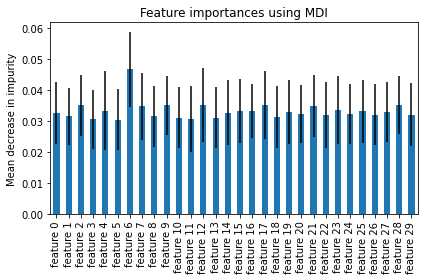

In [18]:
import matplotlib.pyplot as plt
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### try to reconstruct

In [19]:
data_dir

'../pain/output_digestive/Result_IC30'

In [20]:
df_contrib = np.load(os.path.join(data_dir, 'mod_contribution.npy'))

In [21]:
df_contrib.shape

(45, 30)

In [22]:
topIC = df_contrib[:,6]

<BarContainer object of 45 artists>

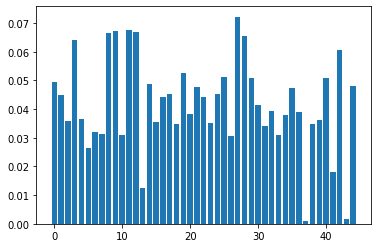

In [23]:
plt.bar(np.arange(len(topIC)), topIC)

In [24]:
topmods = np.argsort(topIC)
print(topmods)

[37 43 13 41  5 26 33 10  7  6 31 18 38 23 15  2 39  4 34 20 36 32 30 22
 16  1 17 24 35 21 44 14  0 29 40 25 19 42  3 28  8 12  9 11 27]


In [25]:
topIC[topmods]

array([0.00087837, 0.00172135, 0.01244409, 0.01801424, 0.02644157,
       0.03070203, 0.03092243, 0.03100332, 0.03148474, 0.0321167 ,
       0.03399016, 0.03464172, 0.0348505 , 0.03506458, 0.03561149,
       0.03587096, 0.03614712, 0.03649352, 0.03790334, 0.03817536,
       0.03891482, 0.03928868, 0.04158548, 0.04416855, 0.04434118,
       0.04484716, 0.04509239, 0.04538501, 0.04720363, 0.04765294,
       0.04818497, 0.04886737, 0.0494752 , 0.05072519, 0.05100193,
       0.05105581, 0.05261662, 0.06068608, 0.06425168, 0.06533633,
       0.06661568, 0.06688436, 0.06731695, 0.06763477, 0.0722087 ])

In [26]:
df_mod = np.load(os.path.join(data_dir, 'flica_mod27_Z.npy'))

In [29]:
df_mod.shape

(1827095, 30)

In [30]:
img_data = df_mod[:,27]
mask_data = load_mask(img_data)

In [32]:
mask = np.where(mask_data>0)

In [33]:
len(mask[0])

1827095

In [73]:
img_reshape = np.zeros(mask_data.shape)

In [74]:
img_reshape[mask] = img_data

In [75]:
from nibabel import Nifti1Image
img_reshape_ni = Nifti1Image(img_reshape, affine=np.eye(4))

In [76]:
from nilearn.plotting import plot_stat_map,plot_anat,plot_epi

In [77]:
mask_path = './MNI152_T1_1mm_brain.nii.gz'

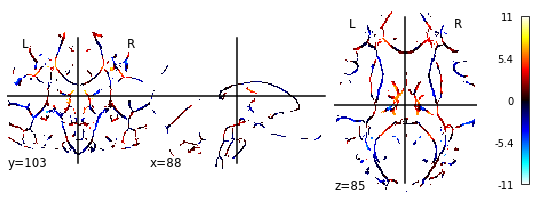

In [81]:
plot_stat_map(img_reshape_ni, bg_img=None)

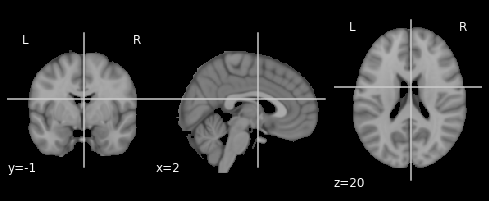

In [61]:
plot_anat(mask_path)

#### try pain patients clf

In [3]:
df_out = full_labels('patients_pain', save=False)
# df_out = full_labels('digestive')

./labels/label_patients_pain.csv
(2724, 1)
(2724, 6)


In [4]:
data_dir = '../pain/output_patients/Result_IC30'

In [6]:
df_featout_ex = remove_subjs(data_dir, df_out)

In [7]:
df_featout_ex.shape

(2280, 36)

In [10]:
cv_classify(df_featout_ex, classifier='rforest', cv_fold=10, scaler=True, balance=True)

4
10-fold CV classification with classifier RandomForestClassifier(max_depth=5):
test ROC AUC=0.5654, test accuracy=0.3260, test f1=0.3260


,fit_time,score_time,test_accuracy,test_f1_micro,test_roc_auc_ovo
0,0.326452,0.028800,0.300000,0.300000,0.597320
1,0.324844,0.028314,0.346667,0.346667,0.589716
2,0.324882,0.027864,0.340000,0.340000,0.560038
3,0.324210,0.027889,0.313333,0.313333,0.542180
4,0.326269,0.028036,0.340000,0.340000,0.573514
5,0.324385,0.028222,0.340000,0.340000,0.562662
6,0.325008,0.028870,0.300000,0.300000,0.532095
7,0.324642,0.028486,0.300000,0.300000,0.543938
8,0.324860,0.028369,0.360000,0.360000,0.577464
9,0.325719,0.029325,0.320000,0.320000,0.574853


In [11]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = data_prep(df_featout_ex)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

In [12]:
y_test.value_counts()

osteoarthritis              221
irritable bowel syndrome    160
migraine                     95
back pain                    94
dtype: int64

In [13]:
y_train.value_counts()

osteoarthritis              664
irritable bowel syndrome    479
migraine                    286
back pain                   281
dtype: int64

In [14]:
from sklearn.ensemble import RandomForestClassifier

feature_names = [f'feature {i}' for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [15]:
import time
import numpy as np

start_time = time.time()
importances = forest.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.013 seconds


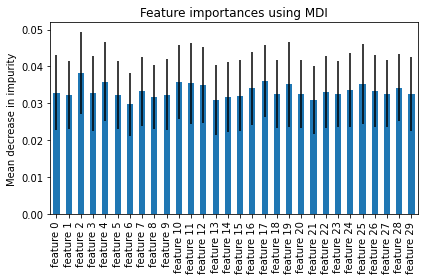

In [16]:
import matplotlib.pyplot as plt
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [17]:
importances[importances.argmax()]

0.03826774832233047